In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import fitsio
from astropy.table import Table, hstack

from desispec.io import read_spectra

# set global plotting variables
sns.set(style='white', context='talk', palette='Set1')
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.dpi"] = 200
plt.rcParams["axes.grid.which"] = 'both'
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['ytick.major.size'] = 4
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams["legend.title_fontsize"] = 8
plt.rcParams.update({'axes.titlesize': 16,
                     'axes.labelsize': 16,
                     'legend.fontsize': 8})

In [2]:
# useful functions

def getFastspecModel(fastspecfile):
    '''
    Reads in fastspec model and preps it for subtraction
    '''
        
    # read in the metadata
    modelmeta = Table(fitsio.read(fastspecfile, 'METADATA'))
        
    # read in fastspecfit model
    models, hdr = fitsio.read(fastspecfile, 'MODELS', header=True)
    modelwave = hdr['CRVAL1'] + np.arange(hdr['NAXIS1']) * hdr['CDELT1']
    
    modelflux = [np.sum(m, axis=0).flatten() for m in models]

    return modelwave, modelflux, modelmeta

In [13]:
# function for plotting combined and source flux

def plotSpectra(t, sourceWave, lensWave, sourceModelWave, sourceModelFlux, lensModelWave, lensModelFlux):
    '''
    Plots combined and residual spectra on the same figure with their fastspec
    models overplotted
    
    t [astropy.table.Table] : must include columns with flux of source and lens
    '''
    
    # plot spectra
    fig, ax = plt.subplots(1,1)
    Ls = [None, None, f"Combined Spectrum (z={t['Z_3']:.3f})"]
    for key, L in zip(lensWave.keys(), Ls):
        ax.plot(lensWave[key], t[f'LENS_FLUX_{key.upper()}'], color='#008294', label=L, alpha=0.9)   
        
    ax.plot(t['LENS_MODEL_WAVE'], t['LENS_MODEL_FLUX'], color='#005B6C') #, label='Combined Spectrum Model'
    
    ax.plot(sourceWave['brz'], t['SOURCE_FLUX'], '#bb0f1a', alpha=0.9, label=f"Residual Spectrum (z={t['Z_2']:.3f})")
    ax.plot(t['SOURCE_MODEL_WAVE'], t['SOURCE_MODEL_FLUX'], color='#8A0510') #, label='Residual Spectrum Model'
   
    
    # make them look pretty
    ax.set_ylabel(r'F$_{\lambda}$ [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')
    ax.set_xlabel(r'Wavelength [$\AA$]')
    ax.legend(title=f"TARGETID: {t['TARGETID_2']}")
    
    info = f'''
        Information about DESI Target {t['TARGETID_2']}:\n
        Name: {t['SYSTEM_NAME']}
        RA: {t['RA_COORD']}
        DEC: {t['DEC_COORD']}
        Discoverer: {t['DISCOVERY_ACRONYM']}
        Einstein Radius: {t['THETA_E']}\n
        masterlens lens redshift: {t['Z_LENS']}
        redrock lens redshift: {t['Z_3']}\n
        masterlens source redshift: {t['Z_SOURCE']}
        redrock source redshift: {t['Z_2']}\n
       '''
    print(info)

In [14]:
datadir = '/global/cfs/cdirs/desi/users/nrfran/speclens/' # NOTE: DELETE THE "OLD" once new outputs exist

lensCoadd = os.path.join(datadir, 'coadd-lenses.fits')
sourceCoadd = os.path.join(datadir, 'coadd-source.fits')
lensFastSpecFile = os.path.join(datadir, 'fastspec-lenses.fits')
sourceFastSpecFile = os.path.join(datadir, 'fastspec-source.fits')
rrLensFile = os.path.join(datadir, 'redrock-lenses.fits')
rrSourceFile = os.path.join(datadir, 'redrock-source.fits')
masterlensFile = os.path.join(datadir, 'masterlens-matches.fits')

rrSource = Table(fitsio.read(rrSourceFile))

lensSpec = read_spectra(lensCoadd)
sourceSpec = read_spectra(sourceCoadd)

lensModelWave, lensModelFlux, lensModelMeta = getFastspecModel(lensFastSpecFile)
sourceModelWave, sourceModelFlux, sourceModelMeta = getFastspecModel(sourceFastSpecFile)

rrLens = Table(fitsio.read(rrLensFile))
masterlens = Table(fitsio.read(masterlensFile))

# clean up the data because some of the redrock fits are flagged in the source fastspecfit fit
I1 = np.where(np.isin(lensModelMeta['TARGETID'], sourceModelMeta['TARGETID']) == True)[0]
I = np.where((rrSource[I1]['ZWARN'] == 0) * (rrSource[I1]['DELTACHI2'] > 40))[0]

rrSource = rrSource[I1][I]

rrLens = rrLens[I1][I]
masterlens = masterlens[I1][I]

lensModelWave = lensModelWave
lensModelFlux = np.array(lensModelFlux)[I1][I]
sourceModelWave = sourceModelWave
sourceModelFlux = np.array(sourceModelFlux)[I]

lensFlux = {'b': lensSpec.flux['b'][I1][I],
            'r': lensSpec.flux['r'][I1][I],
            'z': lensSpec.flux['z'][I1][I]}
sourceFlux = sourceSpec.flux['brz'][I1][I]

lensWave = lensSpec.wave
sourceWave = sourceSpec.wave

INFO:spectra.py:291:read_spectra: iotime 3.136 sec to read coadd-lenses.fits at 2023-04-07T12:33:37.442853
INFO:spectra.py:291:read_spectra: iotime 3.628 sec to read coadd-source.fits at 2023-04-07T12:33:42.093687


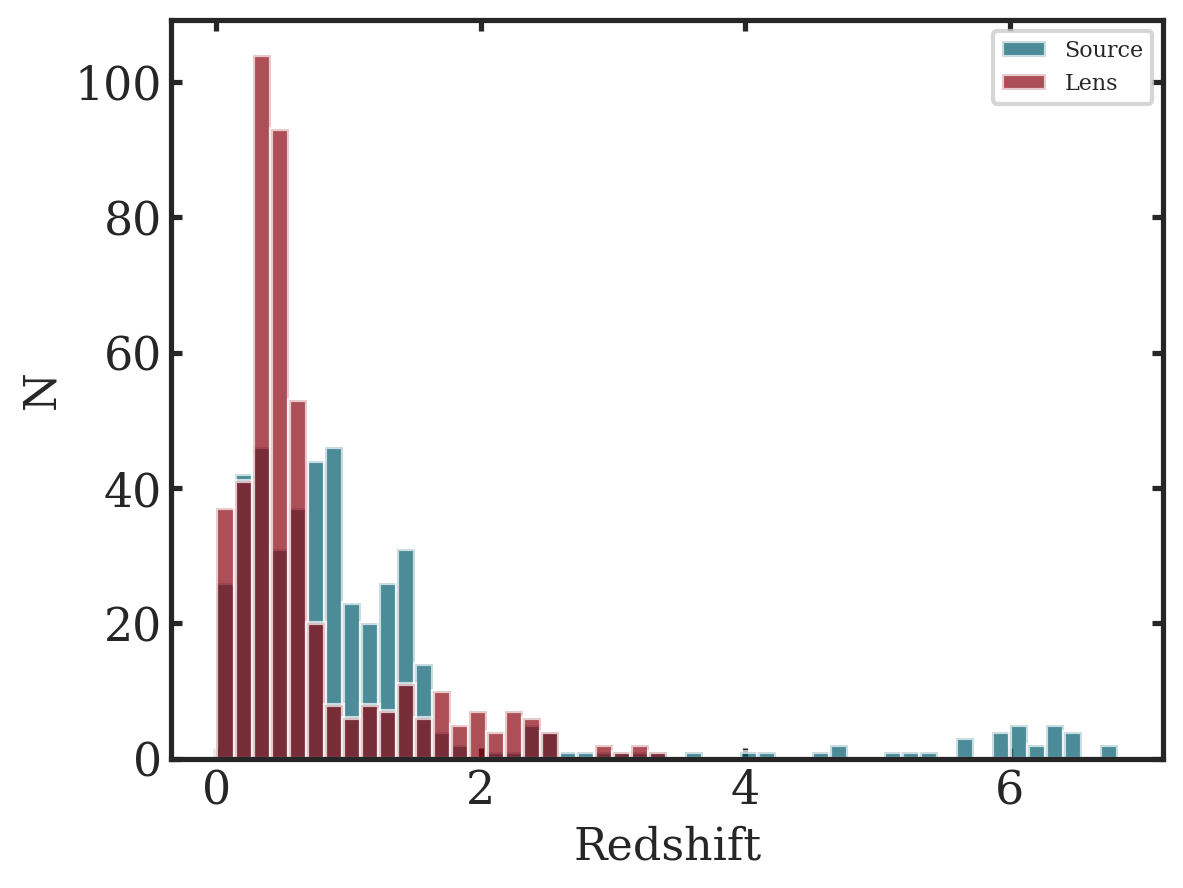

In [27]:
# histogram all the lens redshifts and source redshifts

fig, ax =  plt.subplots()

b = 50
a = 0.7

# source redshifts
_, bins, _ = ax.hist(rrSource['Z'], bins=b, alpha=a, label='Source', color='#005B6C')

# lens redshifts
_, bins, _ = ax.hist(rrLens['Z'], bins=bins, alpha=a, label='Lens', color='#8A0510')

ax.set_ylabel('N')
ax.set_xlabel('Redshift')
ax.legend();

In [16]:
# Create table "z" of all important info for analysis

z = hstack([masterlens, rrSource, rrLens])
z['Z_SOURCE'] = z['Z_SOURCE'].astype(float)
z['SOURCE_FLUX'] = sourceFlux
z['LENS_FLUX_B'] = lensFlux['b']
z['LENS_FLUX_R'] = lensFlux['r']
z['LENS_FLUX_Z'] = lensFlux['z']
z['SOURCE_MODEL_WAVE'] = [sourceModelWave for i in range(len(z))]
z['SOURCE_MODEL_FLUX'] = sourceModelFlux
z['LENS_MODEL_WAVE'] = [lensModelWave for i in range(len(z))]
z['LENS_MODEL_FLUX'] = lensModelFlux

zOld = z[~np.isnan(np.array(z['Z_SOURCE']))]

print(f'{len(z)}/{len(rrSource)} objects have lens redshifts in masterlens')

443/443 objects have lens redshifts in masterlens


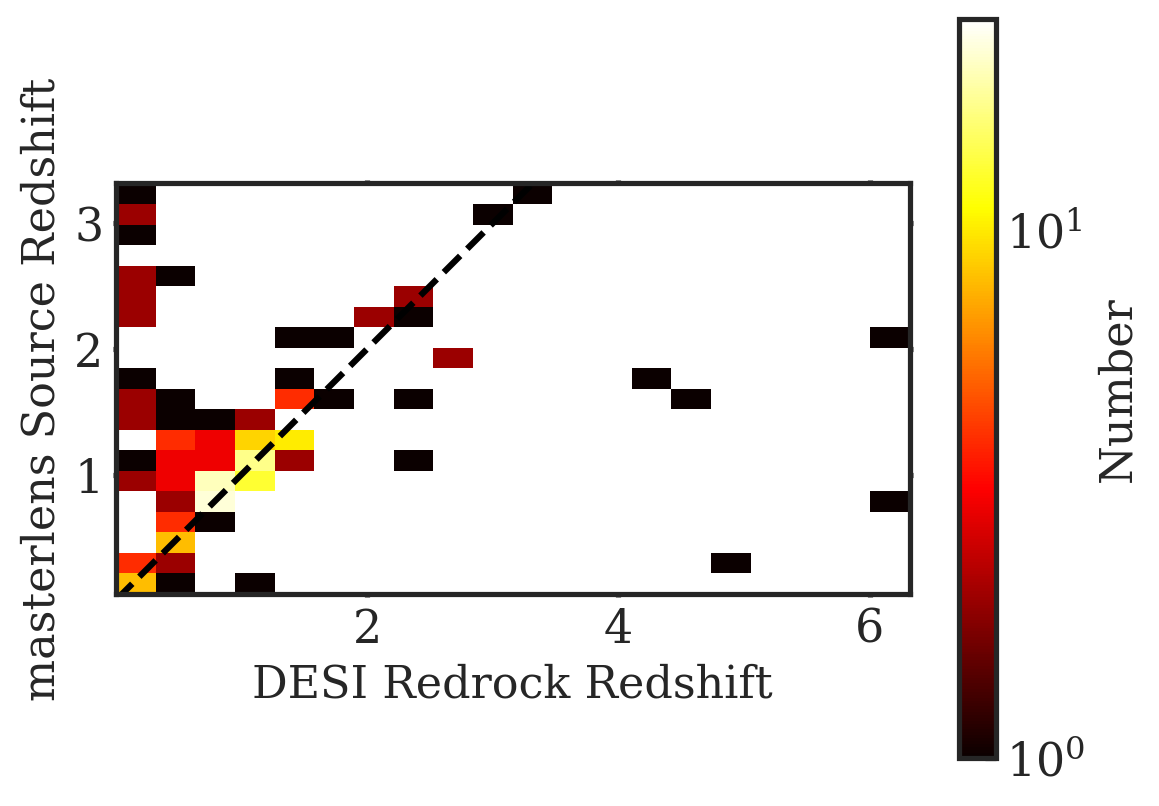

In [17]:
# compare accepted source redshift to our computed source redshift

fig, ax = plt.subplots()
#ax.plot(z['Z'], z['Z_LENS'], '.')
count, xedge, yedge, im = ax.hist2d(zOld['Z_2'], zOld['Z_SOURCE'],
                                    bins=20,
                                    cmap='hot',
                                    norm=LogNorm())
ax.set_ylabel('masterlens Source Redshift')
ax.set_xlabel('DESI Redrock Redshift')

xy = np.linspace(np.min(zOld['Z_2']), np.max(zOld['Z_2']))
ax.plot(xy, xy, 'k--')

ax.set_aspect('equal')
ax.tick_params(axis='both',
               which='major',
               direction='out',
               length=1)
fig.colorbar(im, label='Number')
fig.savefig('redshift-comparison-2dhist.png',
            bbox_inches='tight',
            transparent=False)

In [18]:
dz = 1e-5 # minimum difference between redrock source Z and masterlens source Z

whereMatch = np.where(np.abs(zOld['Z_2'] - zOld['Z_SOURCE']) < dz)[0]

goodZ = zOld[whereMatch]


        Information about DESI Target 39627902119052294:

        Name: J1043+0444
        RA:  160.983708
        DEC:  4.745389
        Discoverer:  ""
        Einstein Radius:  NaN

        masterlens lens redshift:  0.1511
        redrock lens redshift: 0.3322633231018479

        masterlens source redshift: 0.151
        redrock source redshift: 0.1509910622690312

       

        Information about DESI Target 39633034558836881:

        Name: SDSS J1228+3743
        RA:  187.24837
        DEC:  +37.73011
        Discoverer:  "SWELLS"
        Einstein Radius:  NaN

        masterlens lens redshift:  0.03993
        redrock lens redshift: 0.03993625657581866

        masterlens source redshift: 0.102
        redrock source redshift: 0.10200409054170041

       


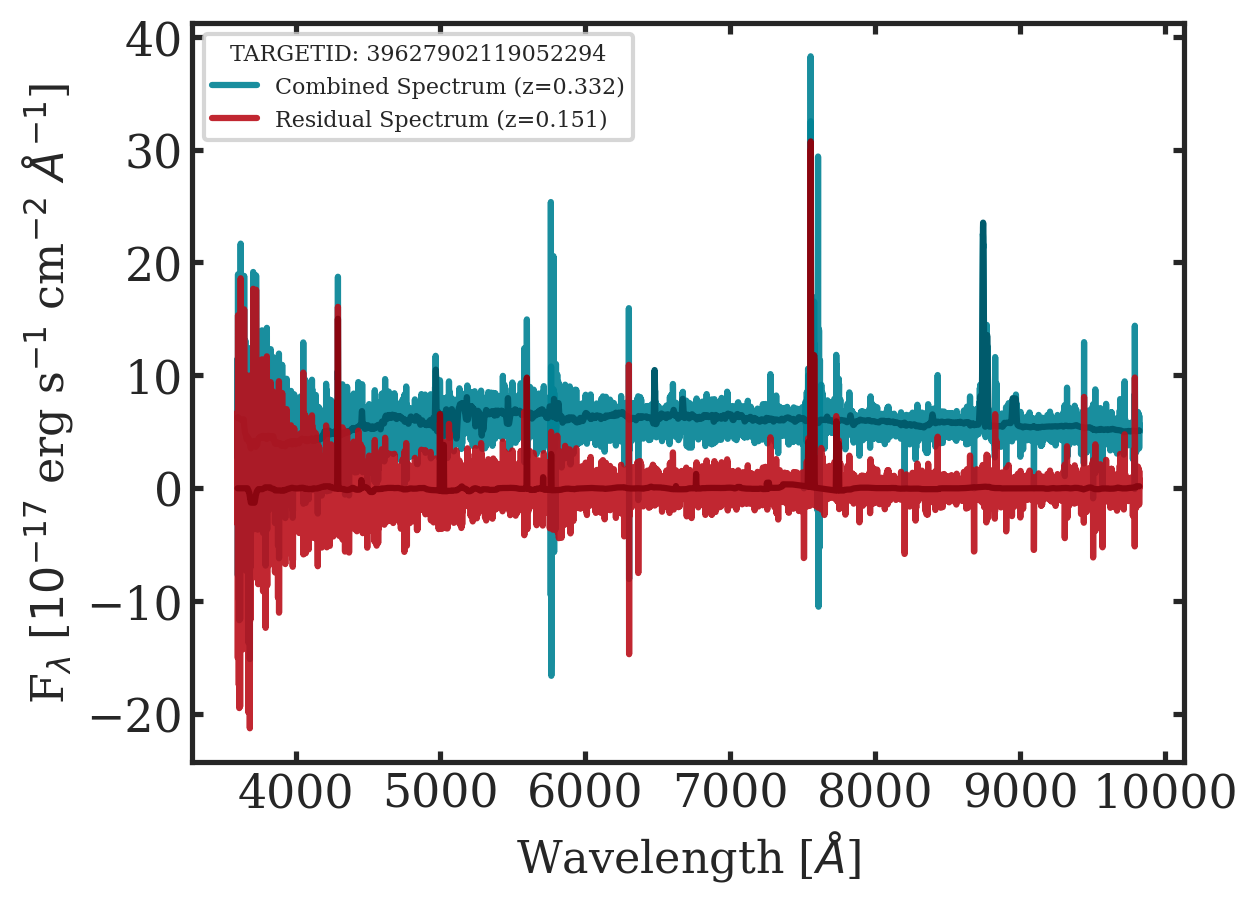

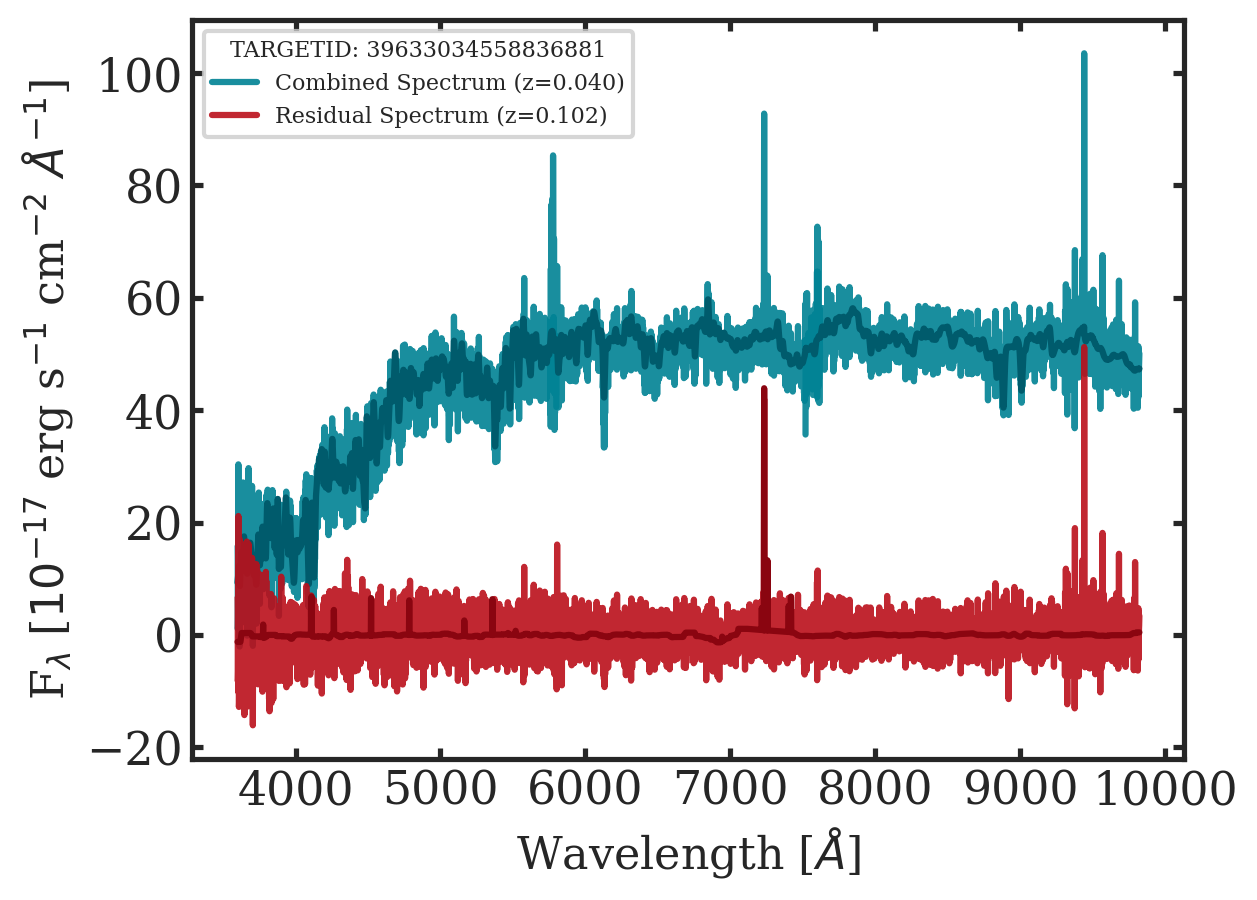

In [19]:
for ii in range(len(goodZ)):
    plotSpectra(goodZ[ii], sourceWave, lensWave, sourceModelWave, sourceModelFlux, lensModelWave, lensModelFlux)

In [20]:
goodSys = goodZ[1]

info = f'''
        Information about DESI Target {goodSys['TARGETID_2']}:\n
        RA: {goodSys['RA_COORD']}
        DEC: {goodSys['DEC_COORD']}
        Discoverer: {goodSys['DISCOVERY_ACRONYM']}
        Einstein Radius: {goodSys['THETA_E']}\n
        masterlens lens redshift: {goodSys['Z_LENS']}
        redrock lens redshift: {goodSys['Z_3']}\n
        masterlens source redshift: {goodSys['Z_SOURCE']}
        redrock source redshift: {goodSys['Z_2']}\n
       '''
print(info)


        Information about DESI Target 39633034558836881:

        RA:  187.24837
        DEC:  +37.73011
        Discoverer:  "SWELLS"
        Einstein Radius:  NaN

        masterlens lens redshift:  0.03993
        redrock lens redshift: 0.03993625657581866

        masterlens source redshift: 0.102
        redrock source redshift: 0.10200409054170041

       



        Information about DESI Target 39627665048605186:

        Name: SDSS J0405-0455
        RA:  61.39756
        DEC:  -4.93122
        Discoverer:  "SLACS"
        Einstein Radius:  0.80

        masterlens lens redshift:  0.07527
        redrock lens redshift: 0.07539440534146895

        masterlens source redshift: 0.81
        redrock source redshift: 0.8098808800224403

       

        Information about DESI Target 39627722028223728:

        Name: SDSS J1451-0239
        RA:  222.86745
        DEC:  -2.66012
        Discoverer:  "SLACS"
        Einstein Radius:  1.04

        masterlens lens redshift:  0.12533
        redrock lens redshift: 0.1253525438422197

        masterlens source redshift: 0.52
        redrock source redshift: 0.5203909181929276

       

        Information about DESI Target 39627745398885131:

        Name: SDSS J1143-0144
        RA:  175.87349
        DEC:  -1.74166
        Discoverer:  "SLACS"
        Einstein Radius:  1.68

        masterlens l

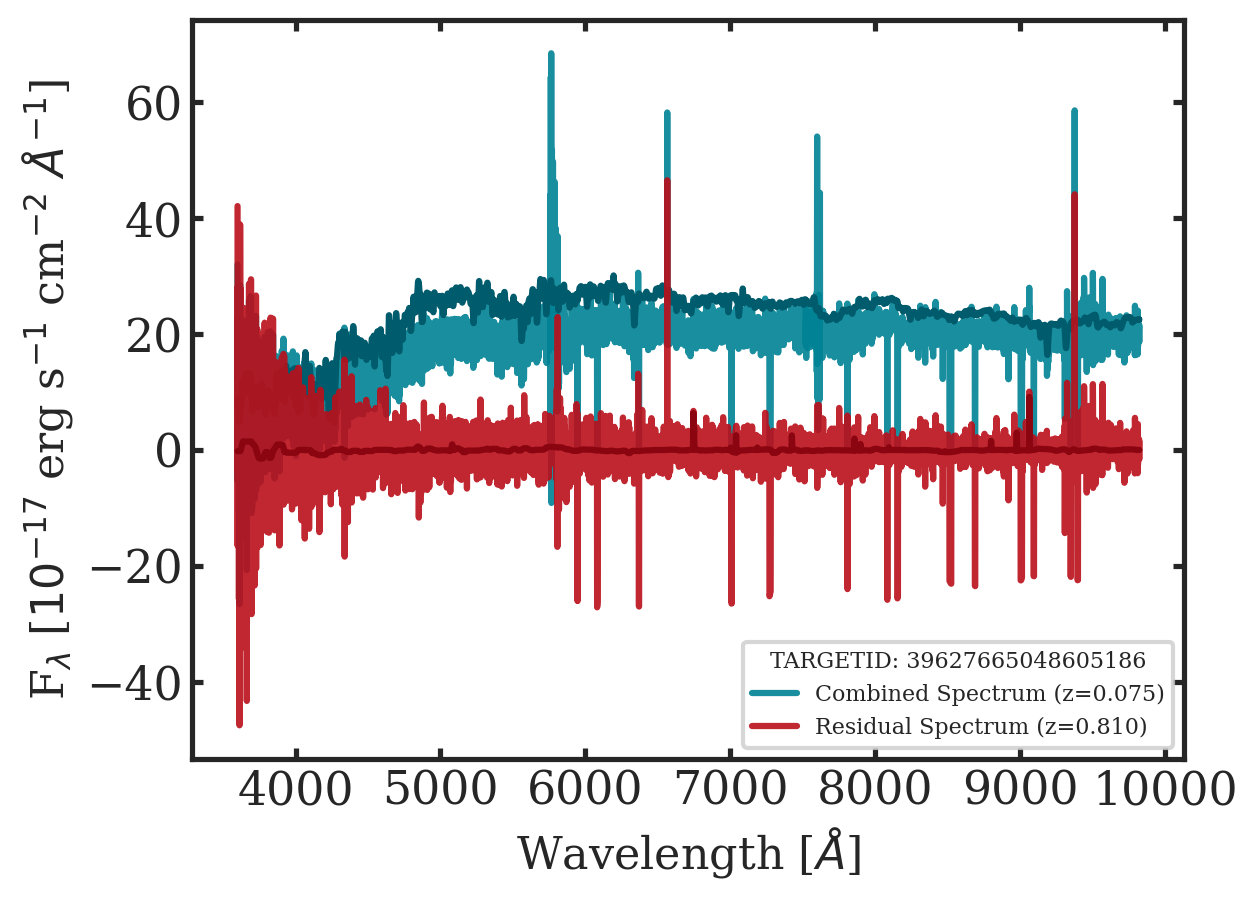

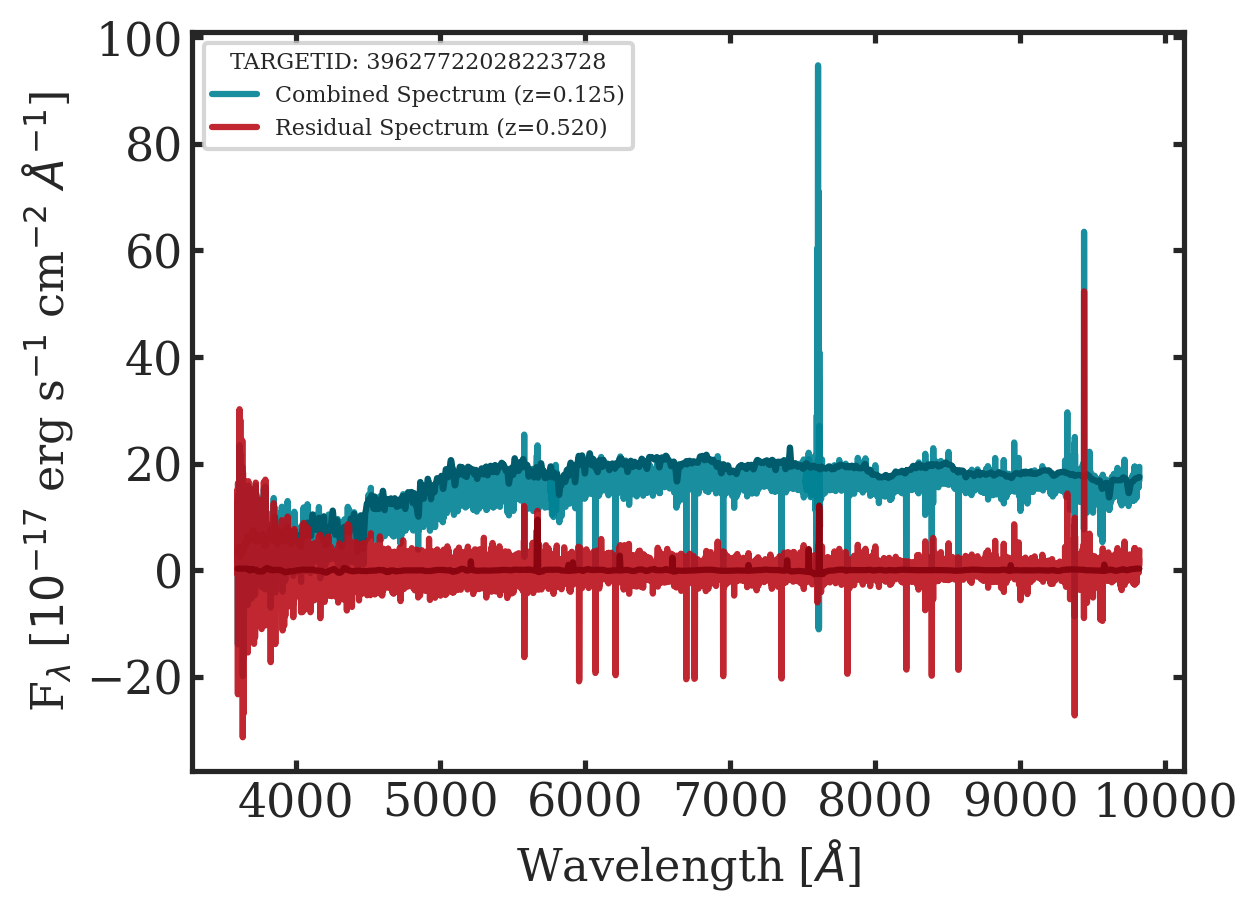

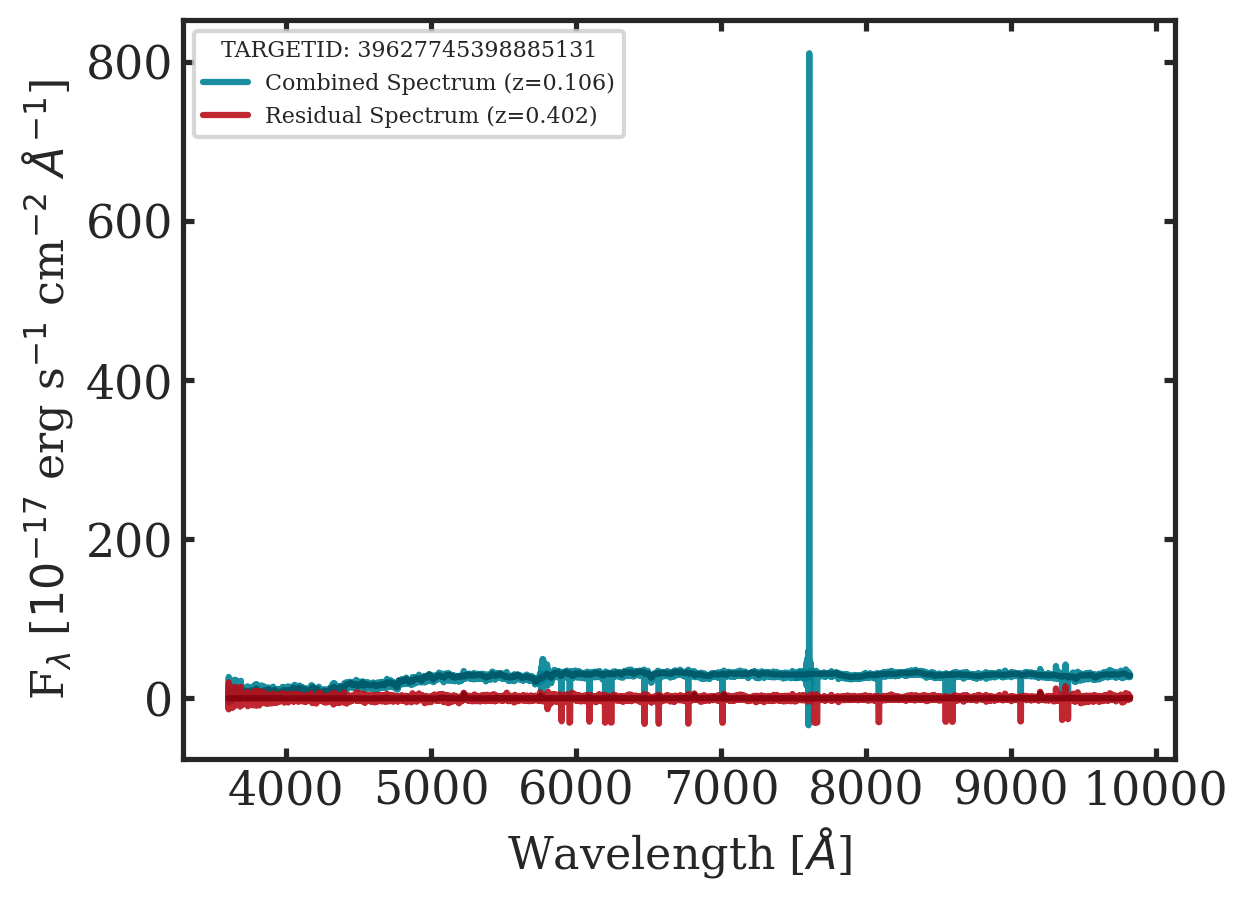

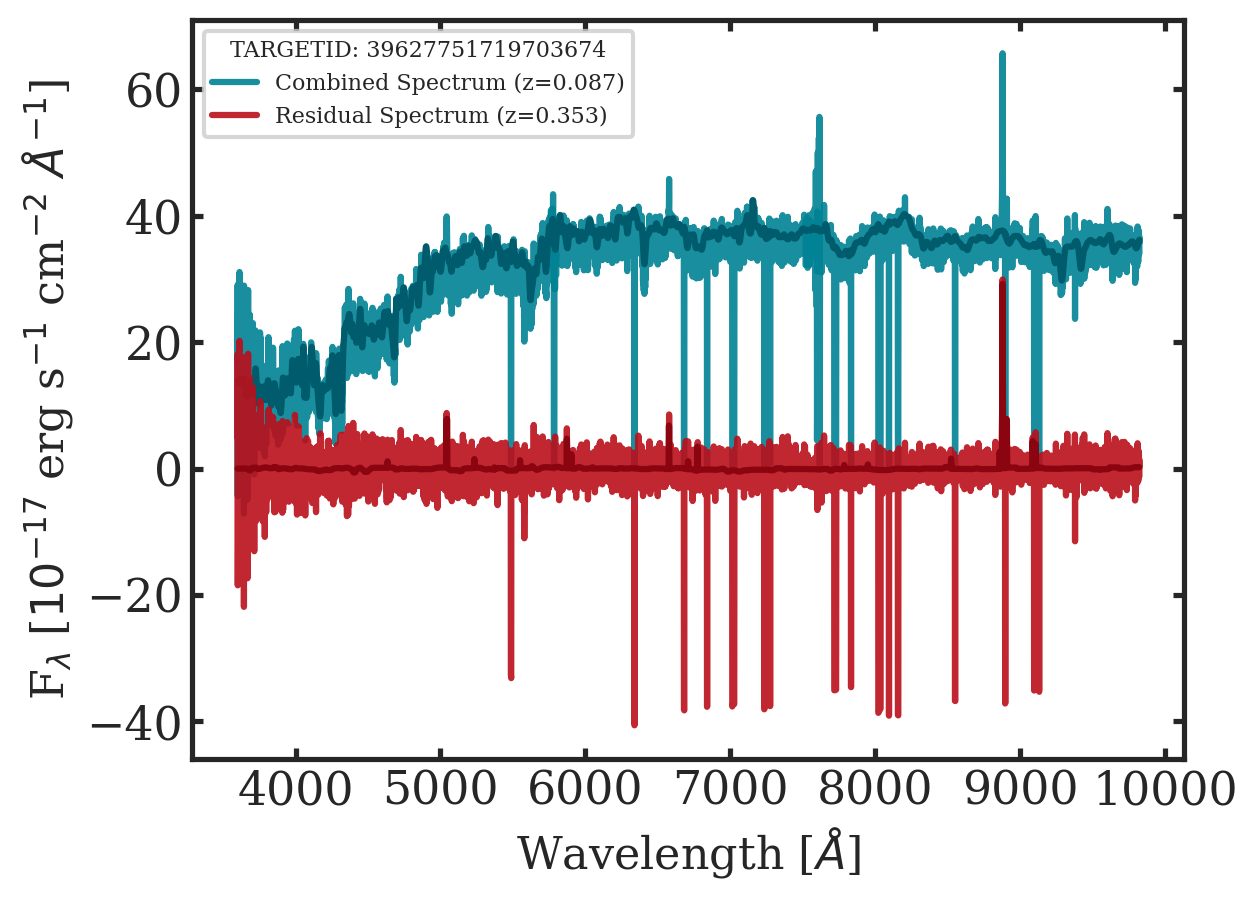

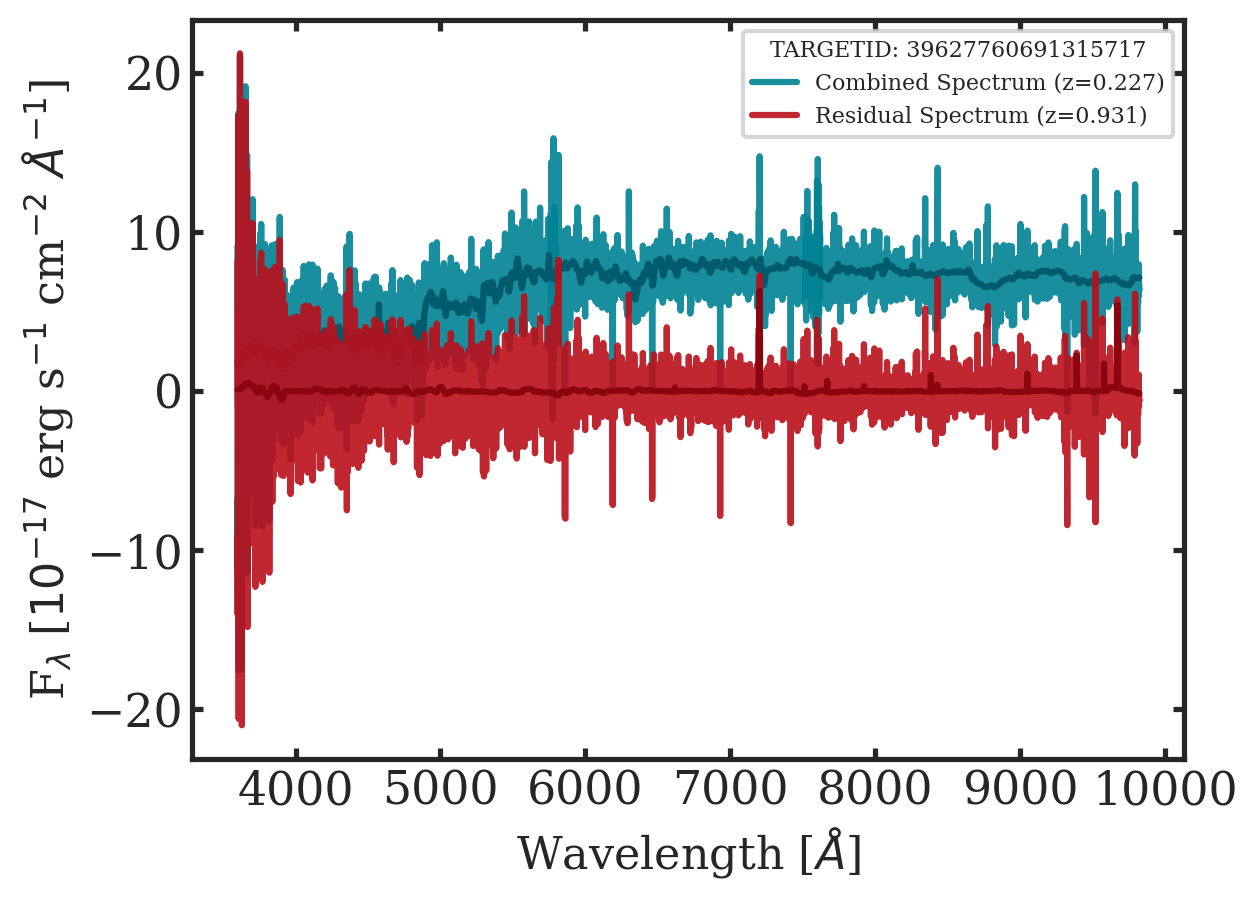

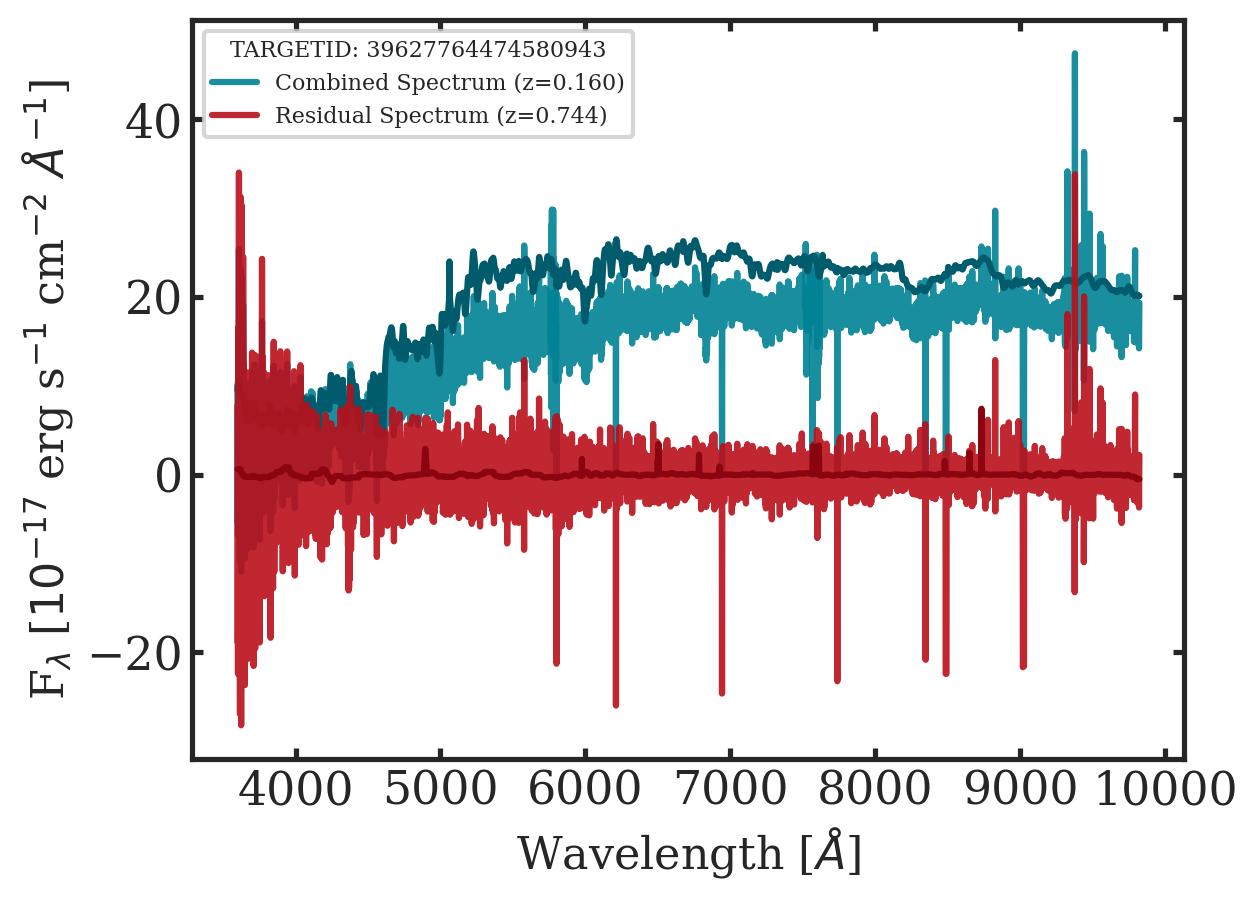

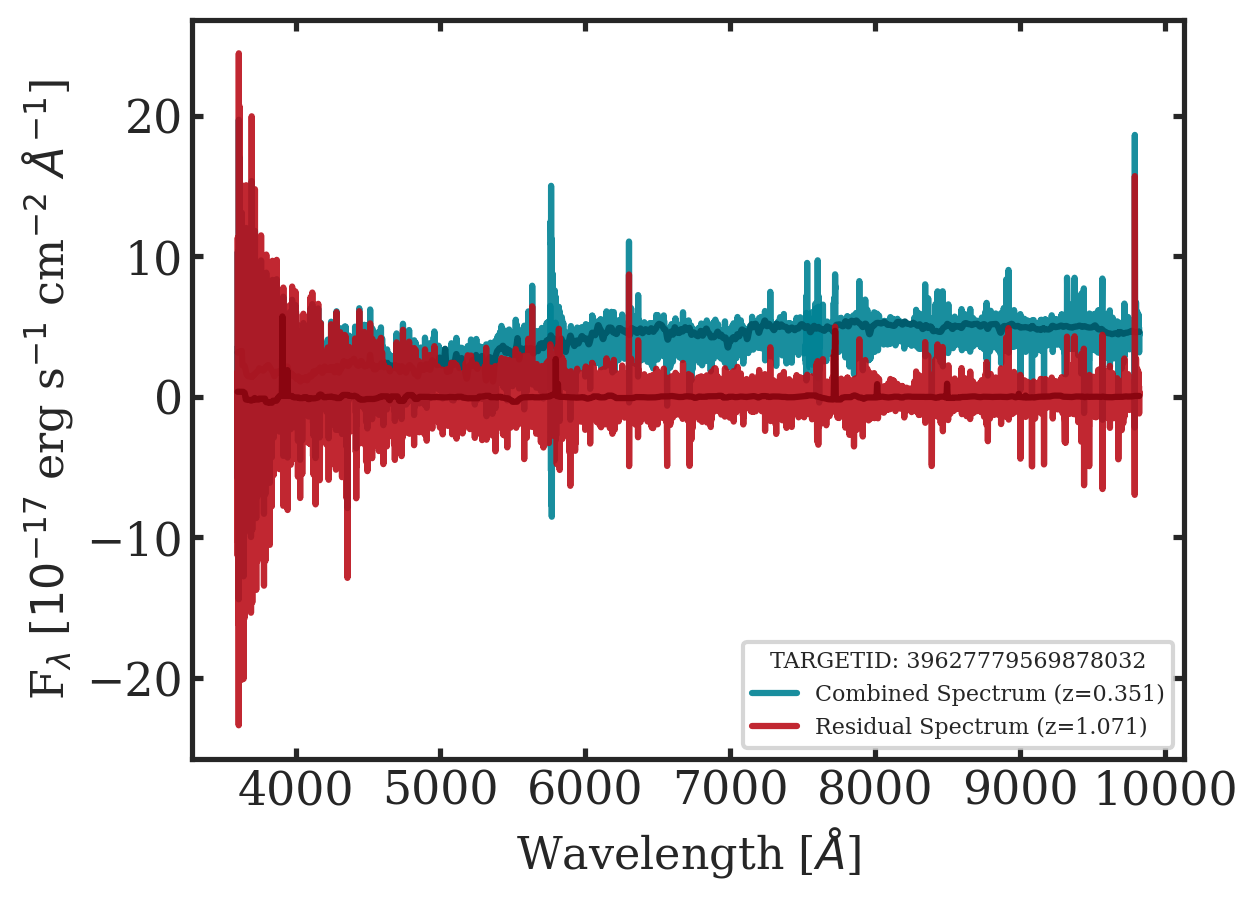

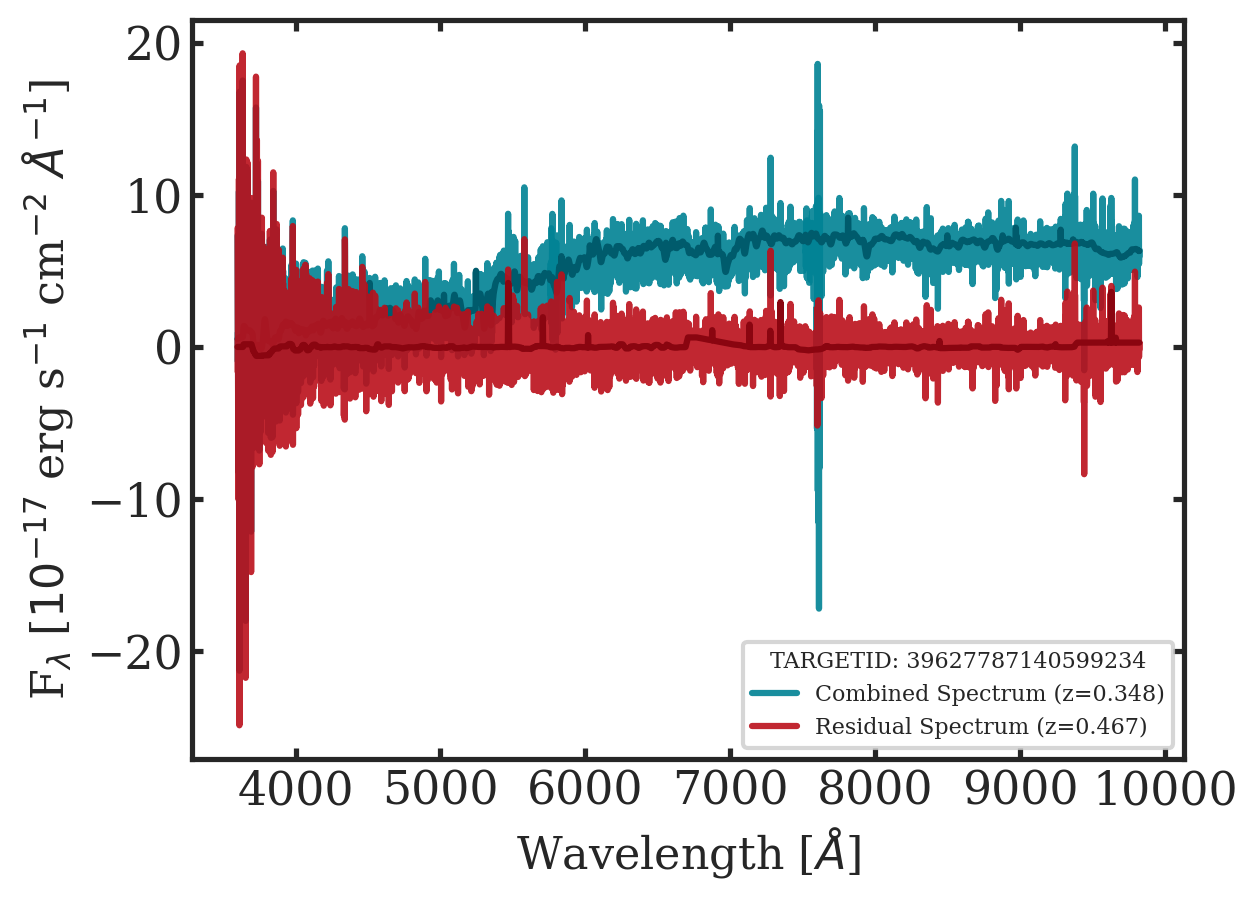

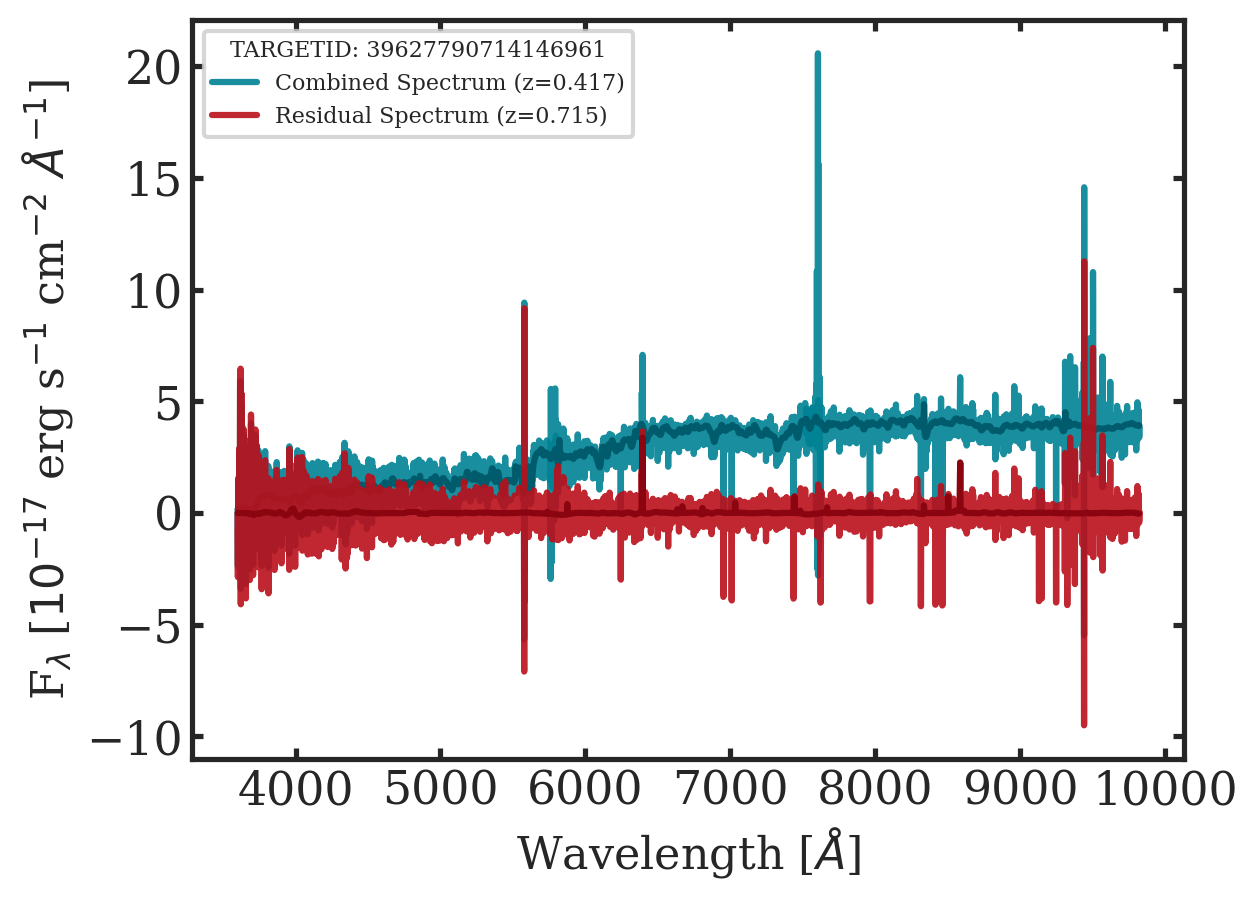

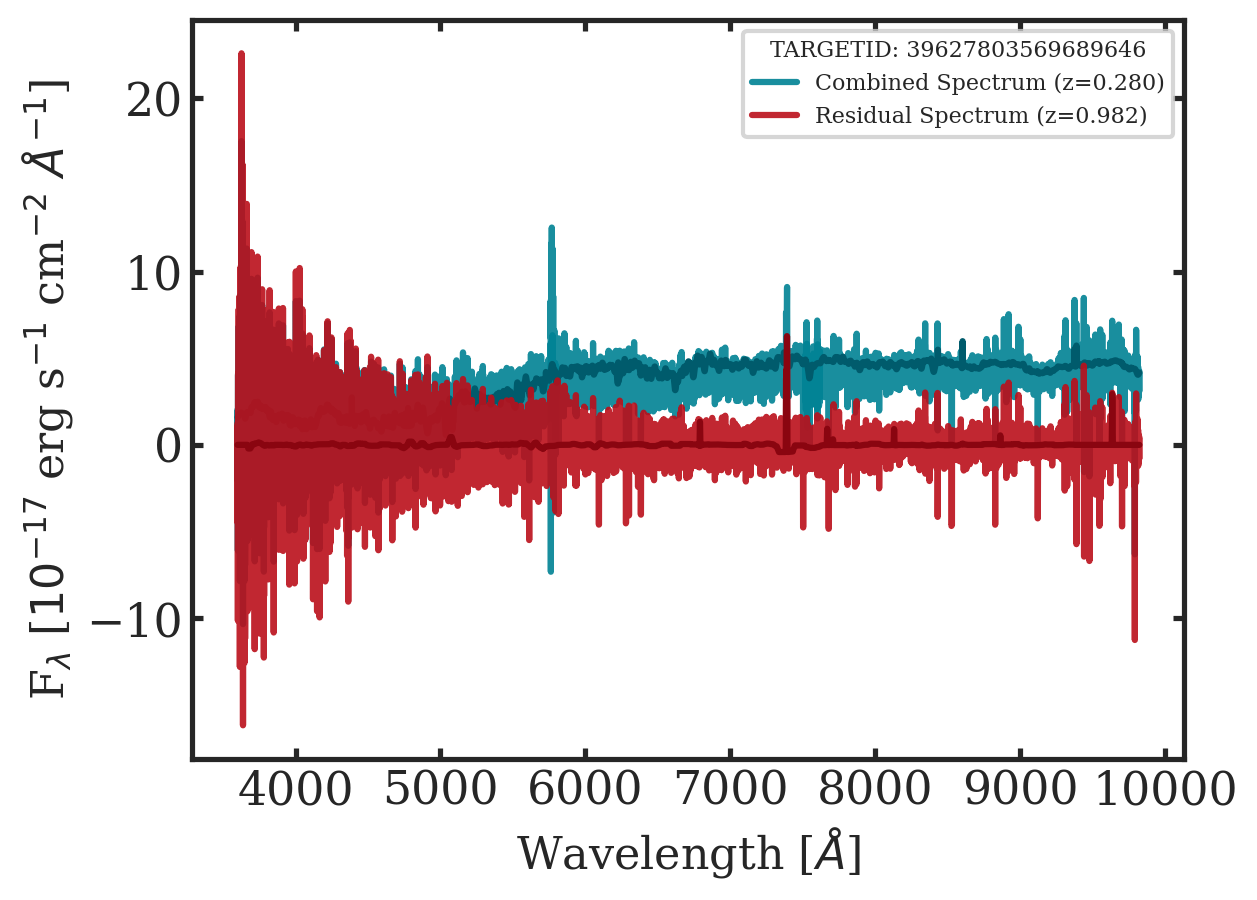

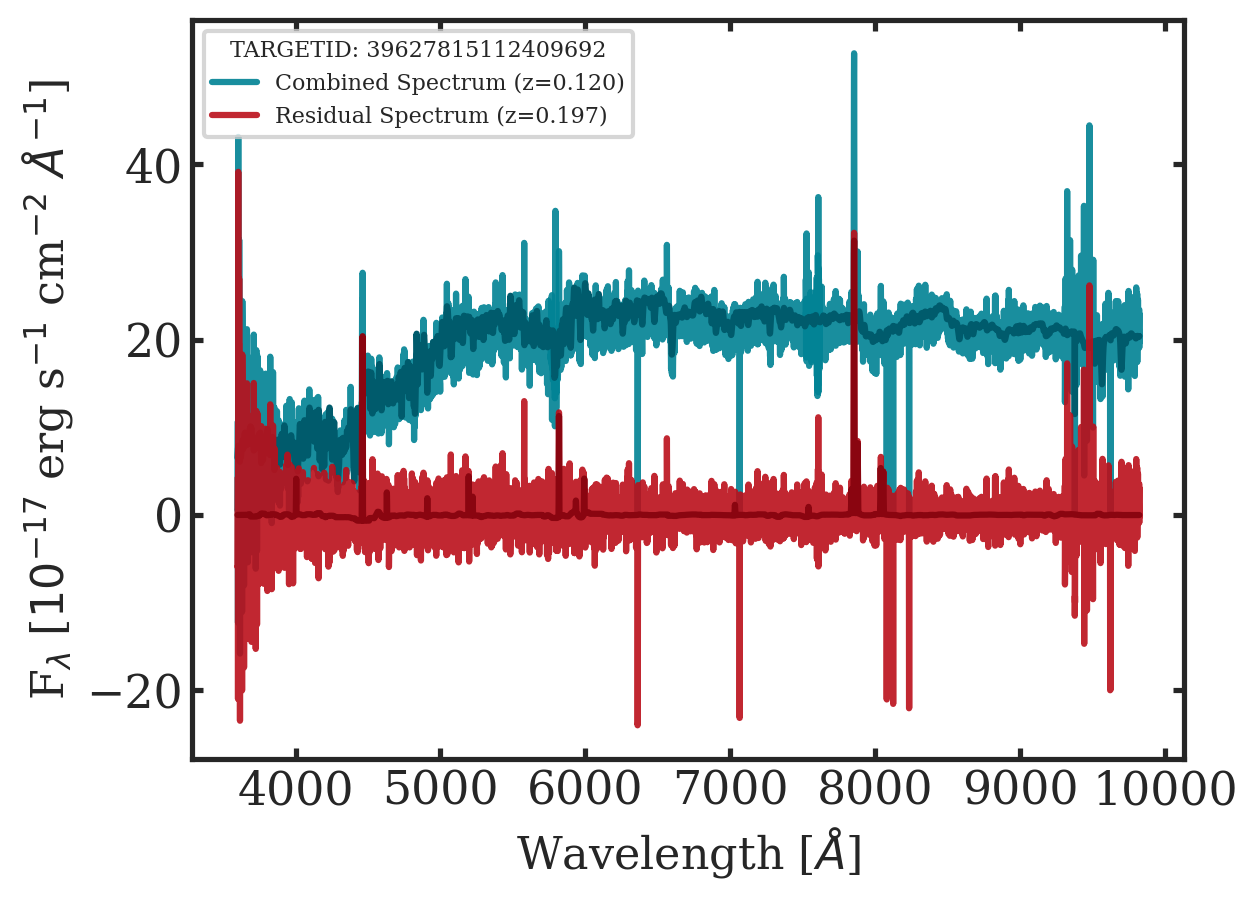

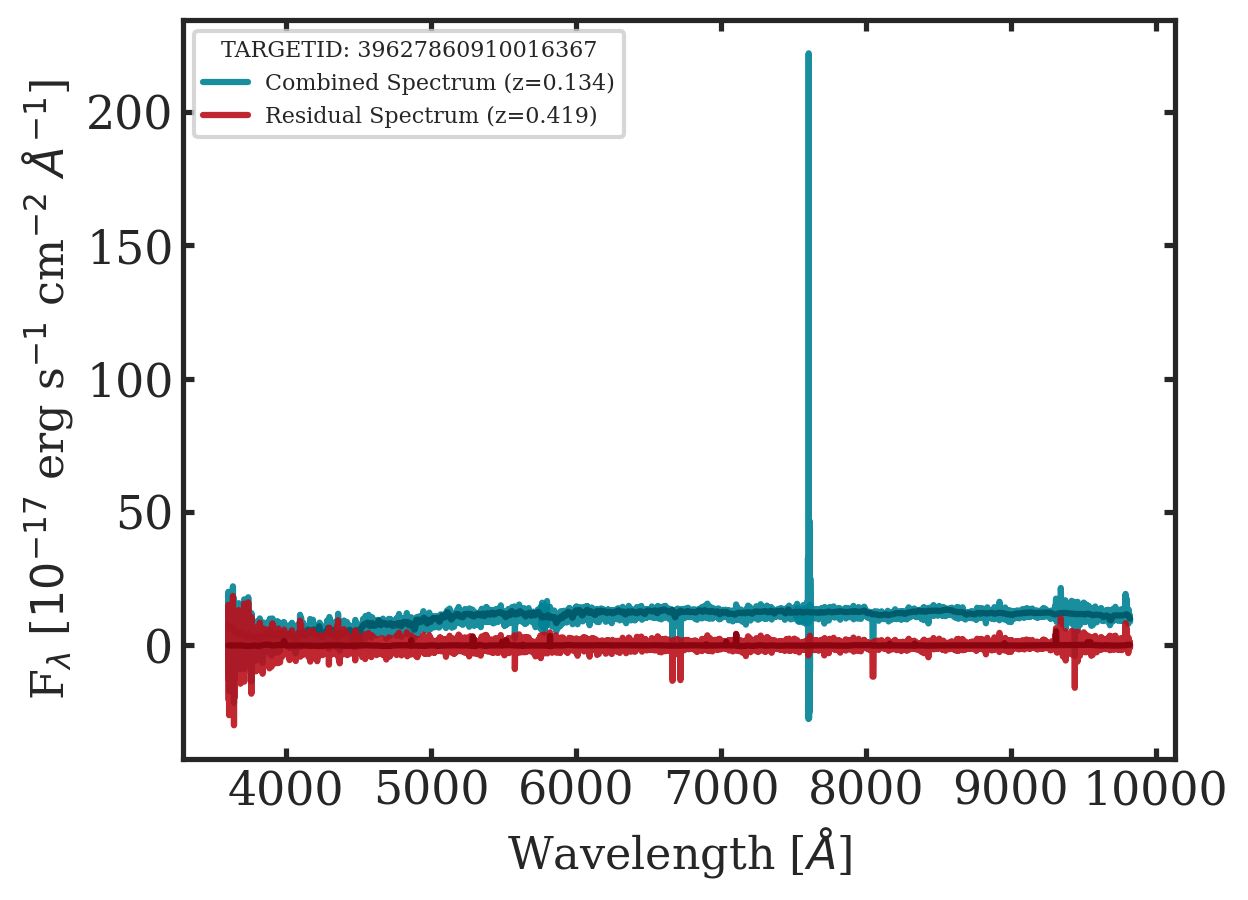

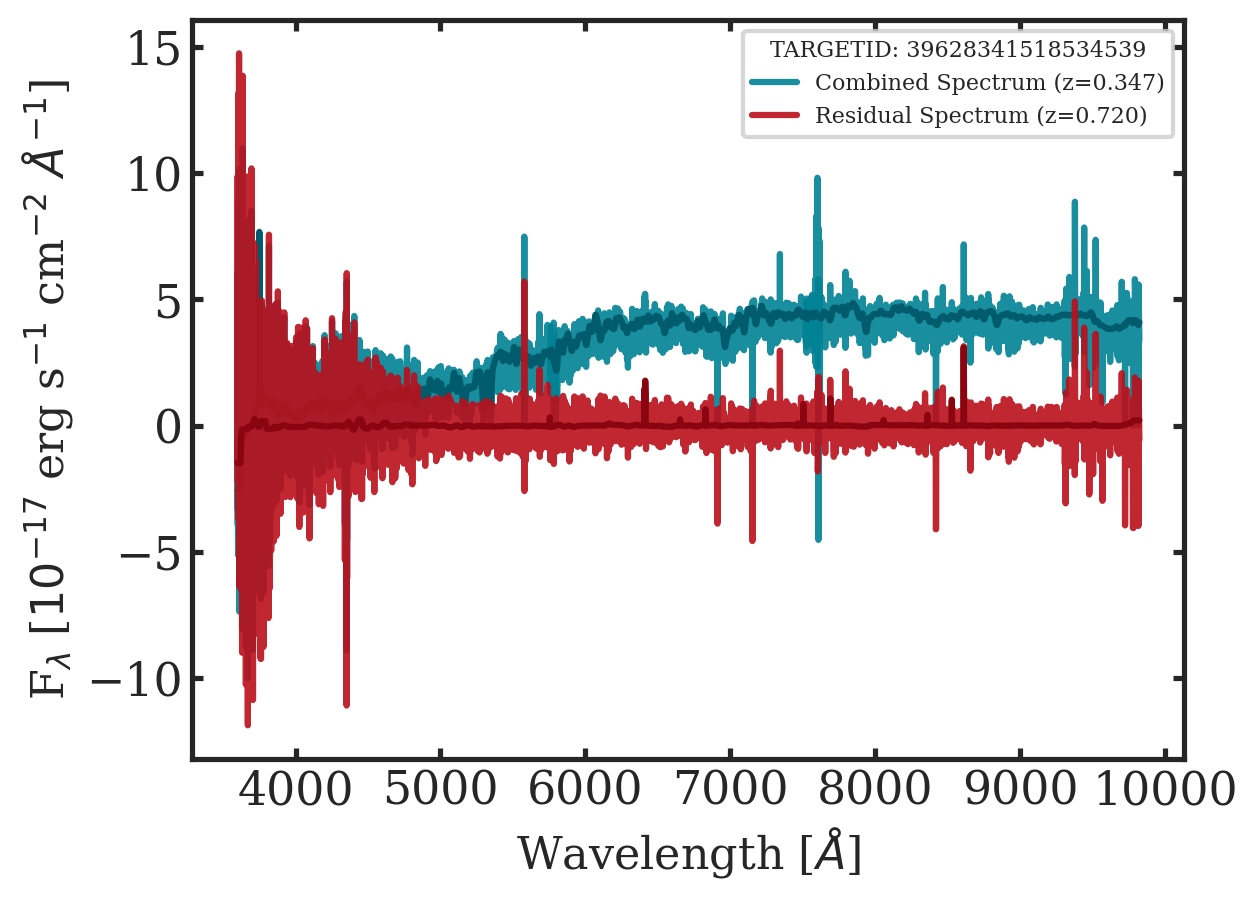

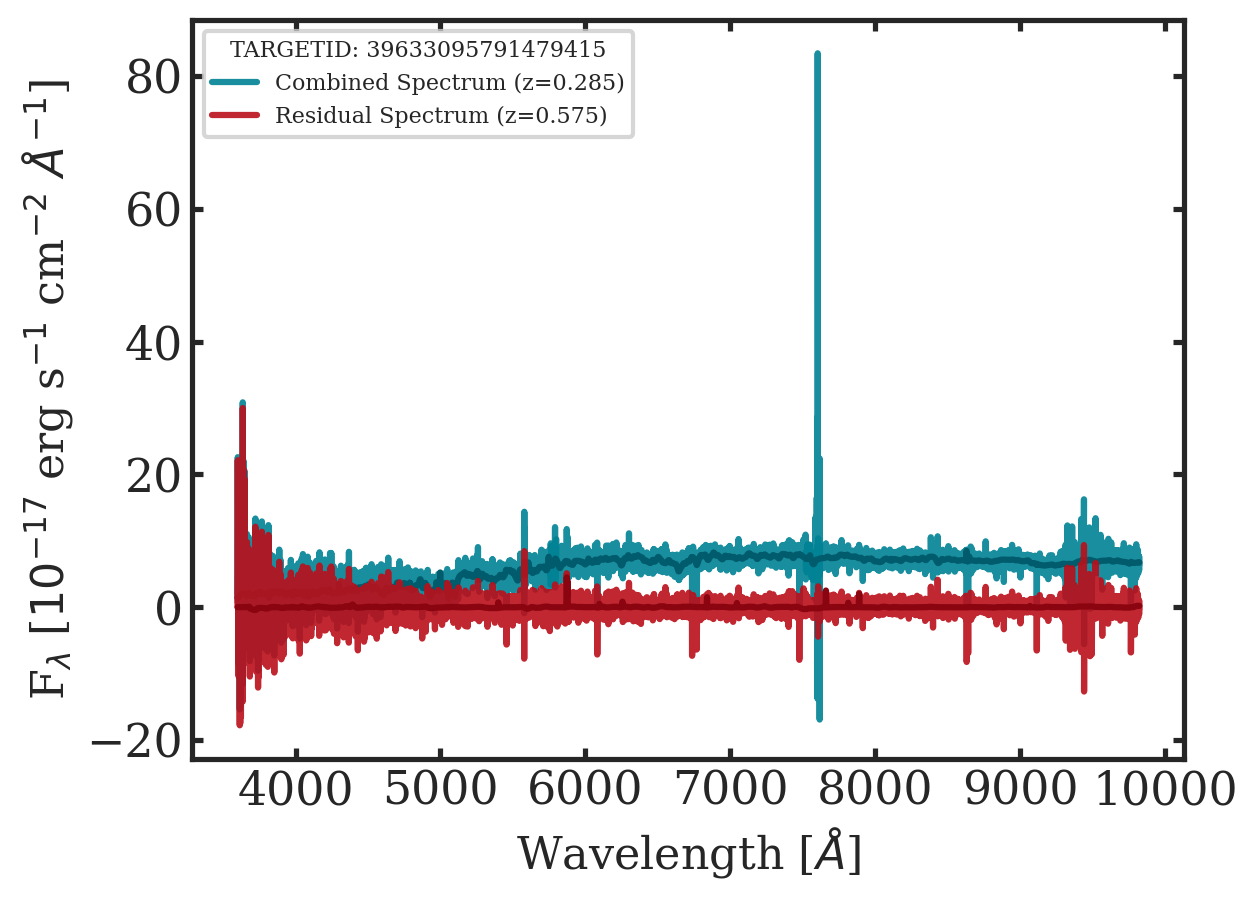

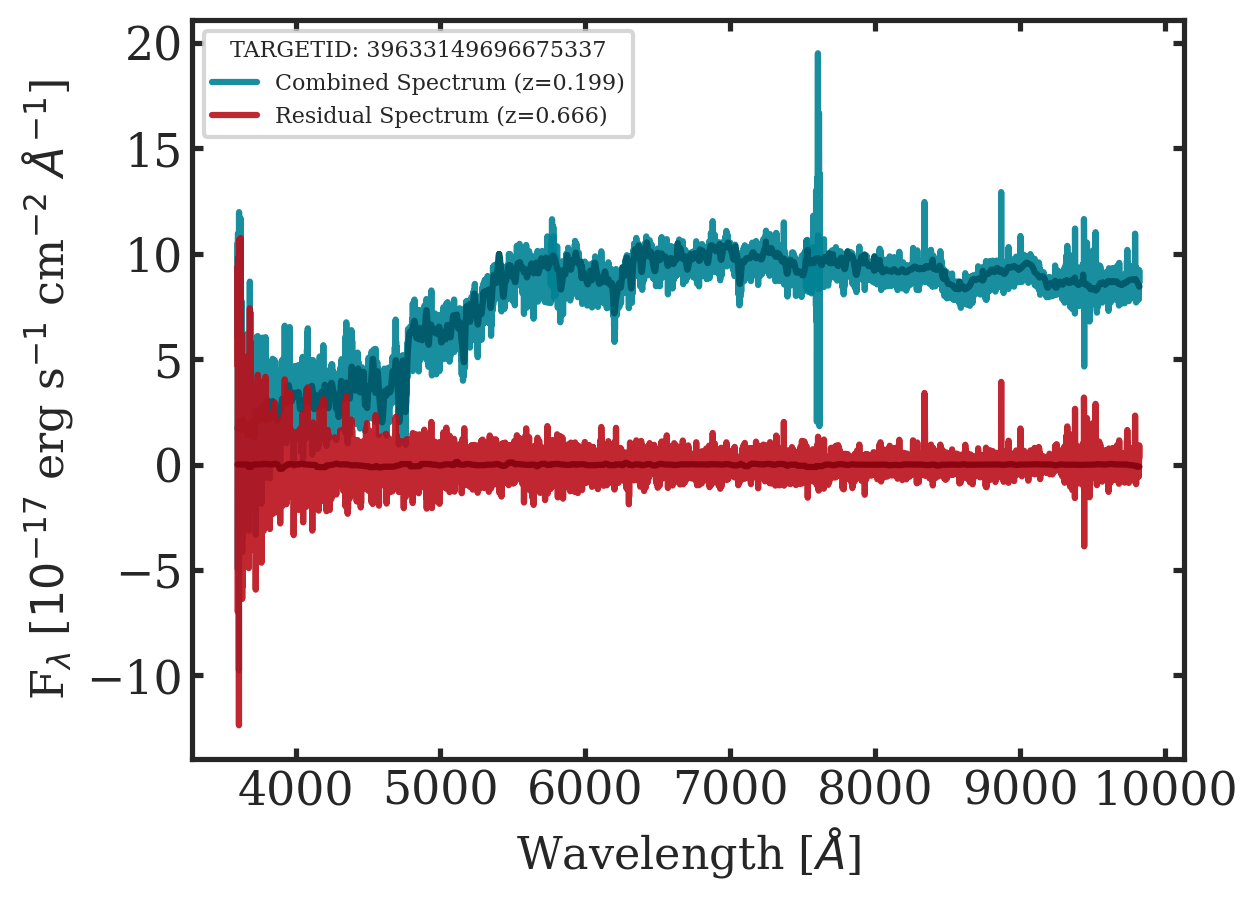

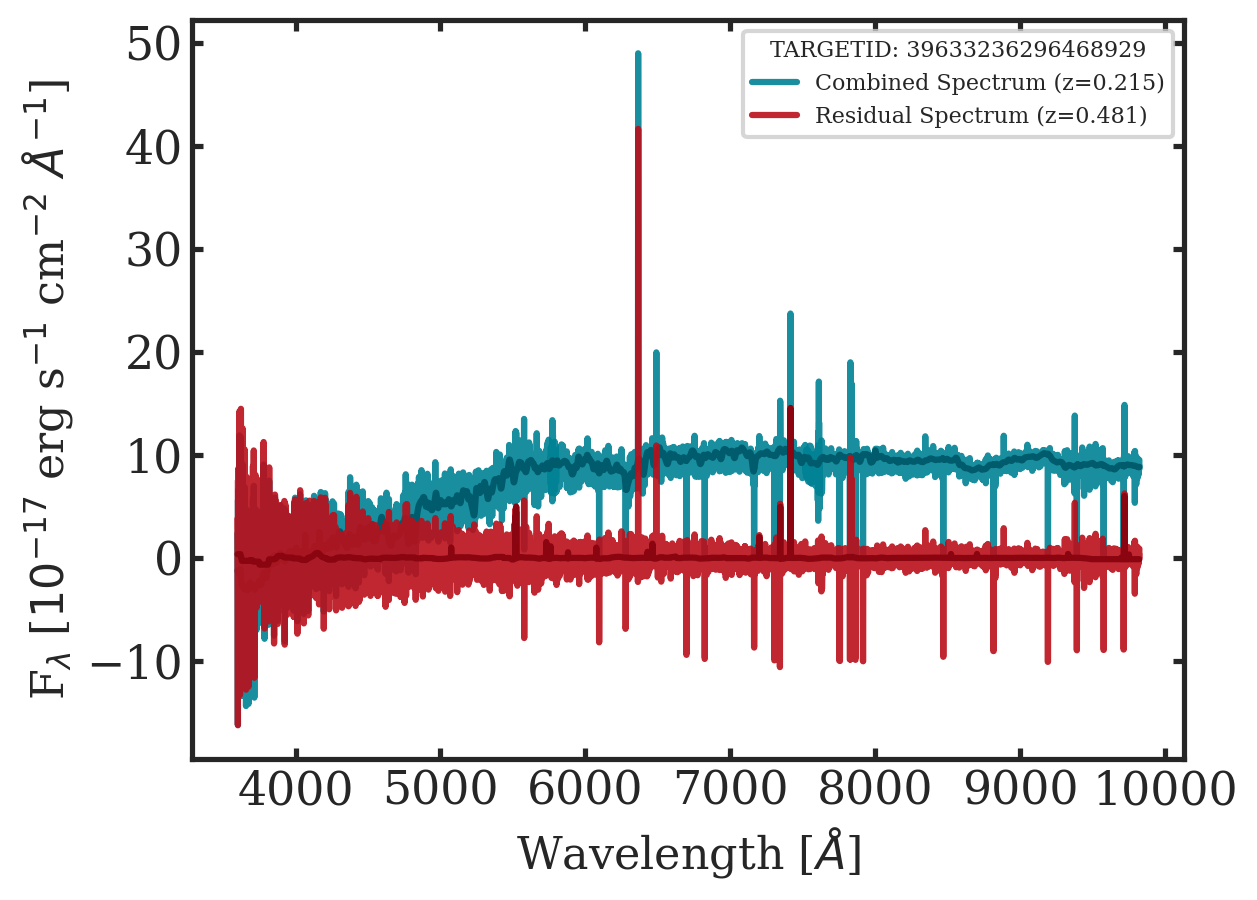

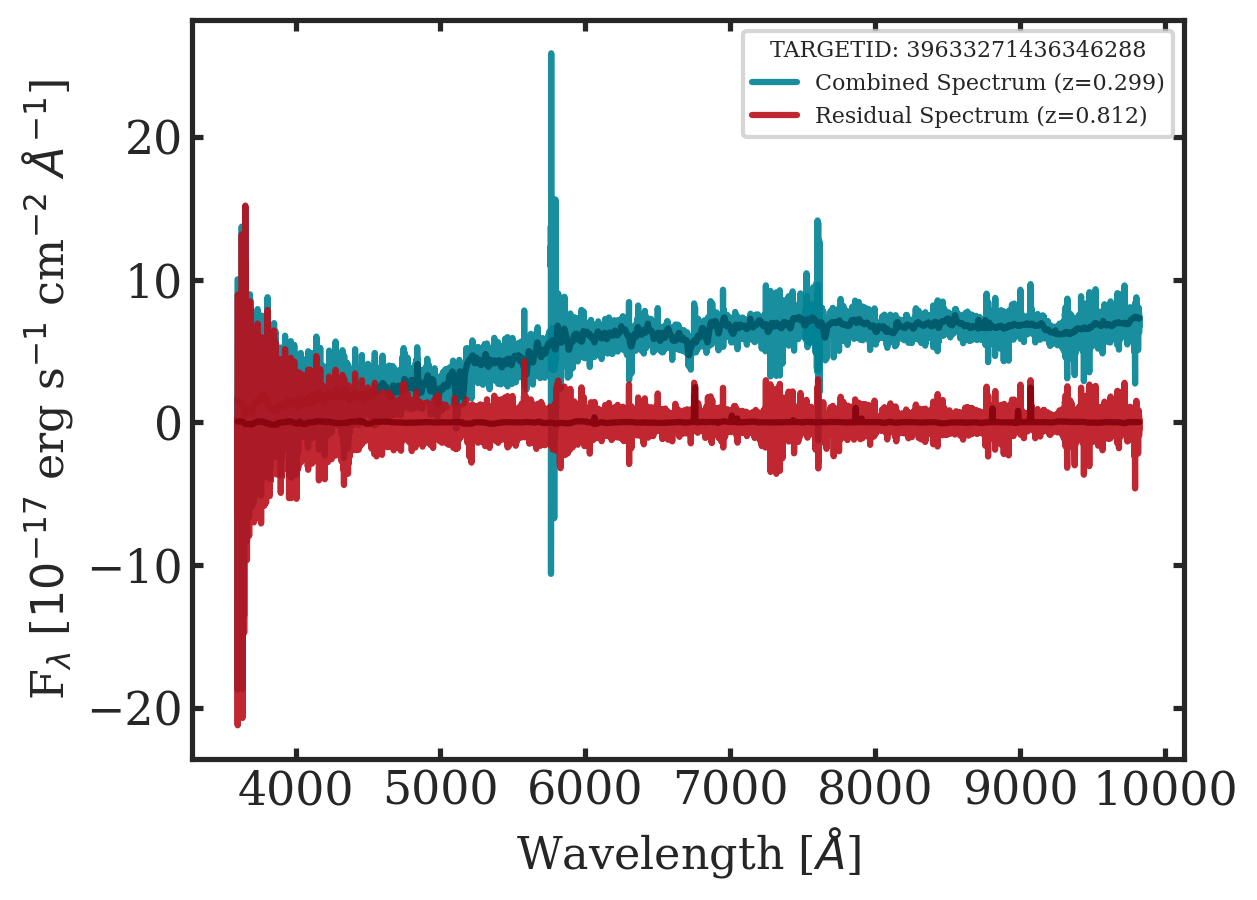

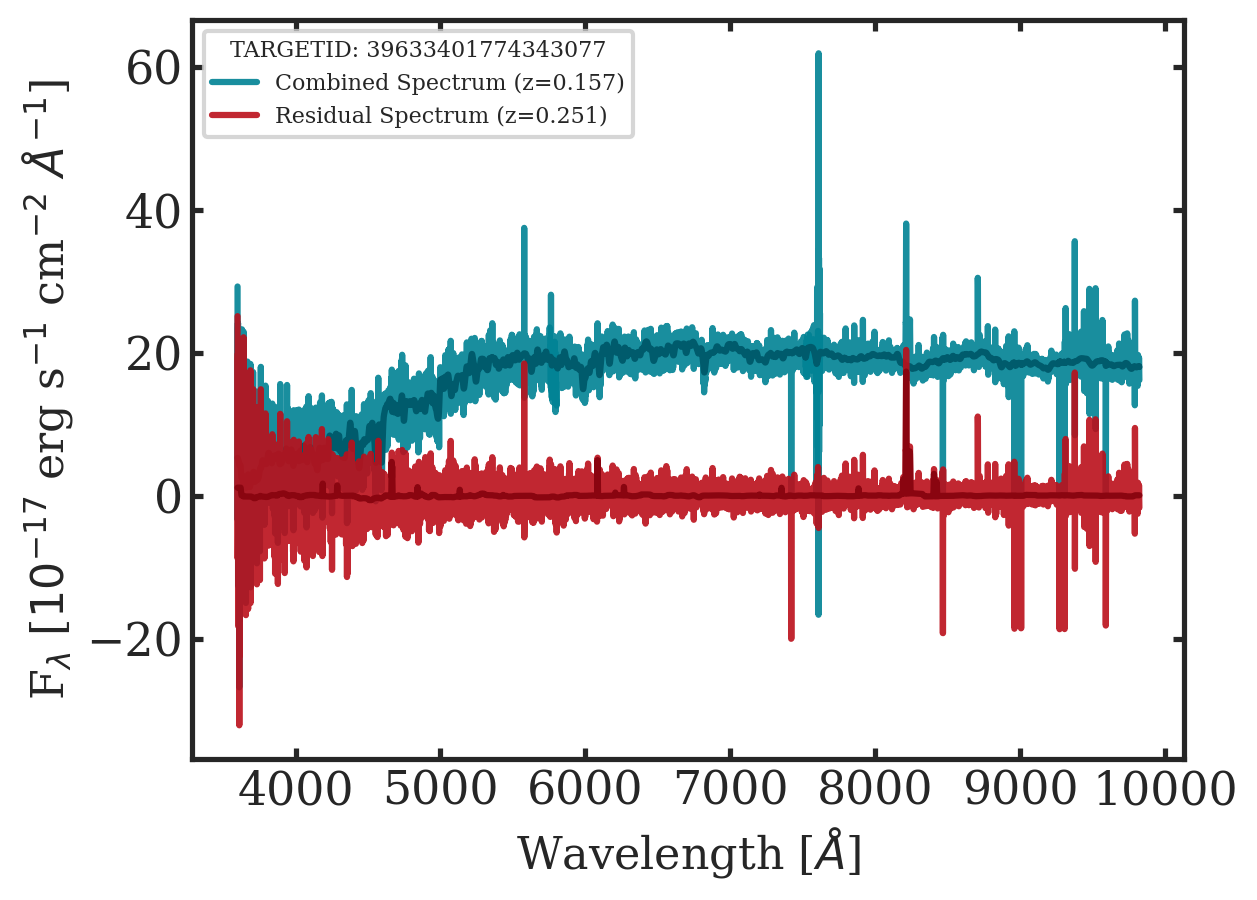

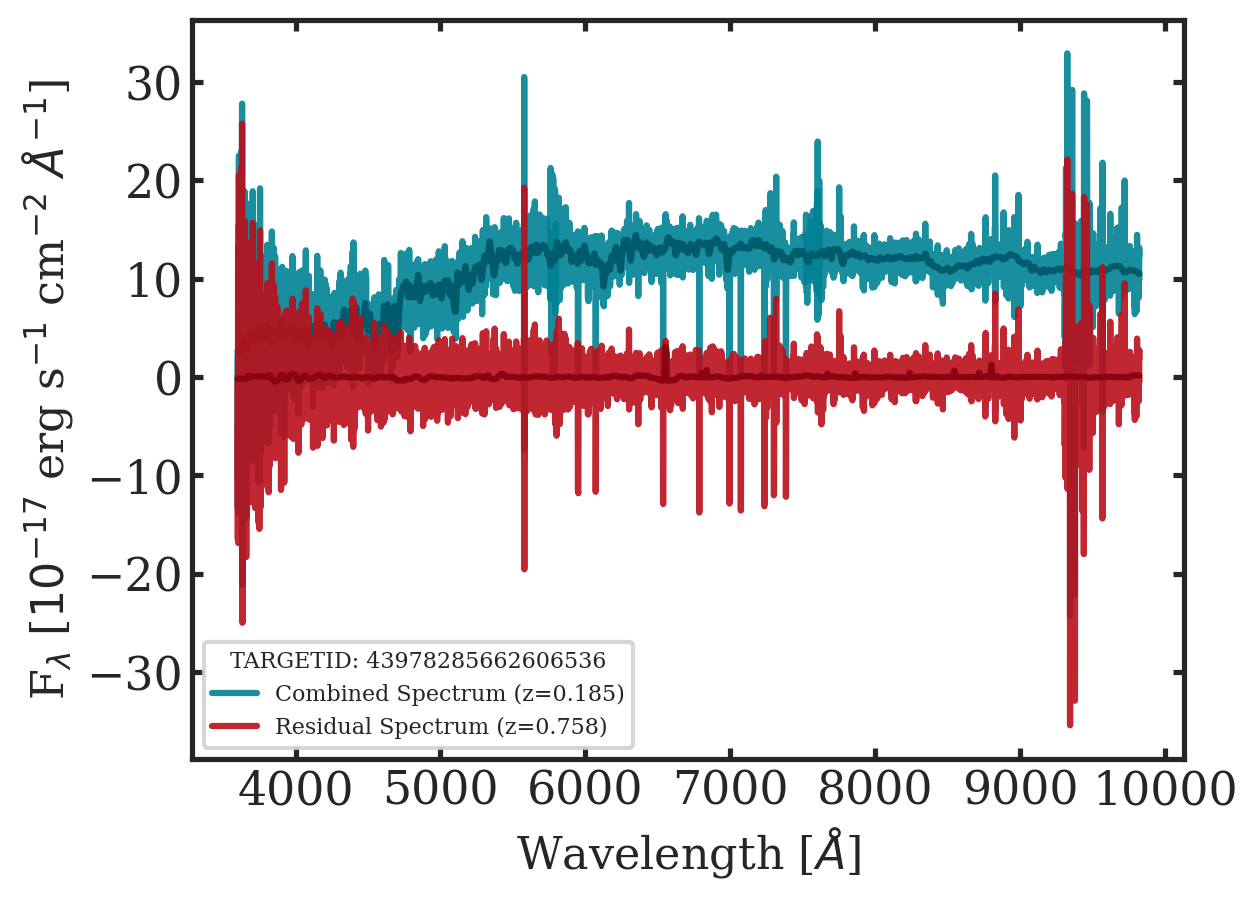

In [21]:
dz = 1000/3e5 # minimum difference between redrock source Z and masterlens source Z

whereMatch = np.where(np.abs(z['Z_2'] - z['Z_SOURCE']) < dz)[0]

slacsZ = z[whereMatch]

slacs = slacsZ['DISCOVERY_ACRONYM'] == ' "SLACS"'

for row in slacsZ[slacs]:
    plotSpectra(row, sourceWave, lensWave, sourceModelWave, sourceModelFlux, lensModelWave, lensModelFlux)

In [22]:
goodZ['SYSTEM_NAME']

J1043+0444
SDSS J1228+3743
